In [ ]:
import cv2
import sqlite3
from matplotlib import pyplot as plt
import numpy as np

from visualize_model import Model
from database import blob_to_array, pair_id_to_image_ids

# 1. 3D mesh reconstruction from a set of images from the Gerrard Hall dataset.
First, we installed Colmap and runned the automatic reconstruction on the Gerrard Hall dataset. 

After running the automatic reconstruction, we visualized the sparse reconstruction directly in COLMAP. This visualization shows the recovered camera poses (in red) and the 3D sparse point cloud representing the structure of the scene. 

<div style="display: flex; gap: 10px;">
  <img src="figures/gerrard_hall_colmap.png" width="45%">
</div style="gap: 10px;">

Next, we exported the dense reconstruction and loaded the resulting meshes into MeshLab for further visualization and processing.

<div style="display: flex; gap: 10px;">
  <img src="figures/gerrard_hall_mesh_before_1.png" width="45%">
  <img src="figures/gerrard_hall_mesh_before_2.png" width="45%">
</div style="gap: 10px;">

However, the raw mesh contained several artifacts and noisy components, especially around the borders and less constrained regions. To improve the final result, we applied different cleaning filters in MeshLab, such as removing isolated components, and manually removed a connected region that corresponded to a reconstruction artifact. The following images correspond to the cleaned versions of the previous meshes, obtained after applying post-processing steps in MeshLab.

<div style="display: flex; gap: 10px;">
  <img src="figures/gerrard_hall_mesh_after_1.png" width="45%">
  <img src="figures/gerrard_hall_mesh_after_2.png" width="45%">
</div style="gap: 10px;">

The final processed mesh can be downloaded from the following link:
[Gerrard Hall Mesh](https://drive.google.com/file/d/1yNNZeB9sxfI0jd5833KQu7Z_Lk0r3WLD/view?usp=drive_link)

# 2. Analyze reconstructions using python
## 2.1. Run the notebook, using the Gerrard Hall reconstruction (0.5)
#### <span style='color:Green'> - Add the path to your reconstruction. Answer the questions at the end  </span>

In [ ]:
# Add your path
reconstruction_path = "/home/arnau-marcos-almansa/workspace/MCV-C4/lab4/gerrard_hall/images/sparse/0"
database_path = "/home/arnau-marcos-almansa/workspace/MCV-C4/lab4/gerrard_hall/images/database.db"

#### Load an existing reconstruction and print its contents

In [ ]:
model = Model()
# model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt
model.read_model(reconstruction_path, ext='.bin')

In [ ]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [ ]:
print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[1])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[1])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
# print(points3D[1]) # TODO: FIX THIS

#### Load the database

In [ ]:
db = sqlite3.connect(database_path)

In [ ]:
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

In [ ]:
print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

In [ ]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")

In [ ]:
# Temporal

dir(matches)
matches.__class__
matches.items()
matches.keys()

In [ ]:
print("These are the matches between two images:")
print(matches[1,3])

#### Visualize the point cloud and cameras

In [ ]:
model.create_window()
model.add_points()
model.add_cameras(scale=0.25)
model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

In [ ]:
print(f"#Keypoints total: {sum(kpts.shape[0] for kpts in keypoints.values())}")

<span style='color:darkcyan'>There are 3112449 keypoints in total.</span> 

#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


In [ ]:
num_points3d_originated_in_image_1 = sum(1 for point3D in points3D.values() if 1 in point3D.image_ids)

print(f"#3d points from image 1: {num_points3d_originated_in_image_1}")

<span style='color:darkcyan'>There are 3210 keypoints in image 1.</span> 

## 2.2 Plot the 3D points coloured according to the number of images and error. (0.5)

#### <span style='color:Green'> - Plot the 3D points coloured according to the **number of images** from which it originated. </span> Can you extract any conclusions from the visualization? 

In [ ]:
### TO DO 2.2

xyz = []
num_images = []
errors = []

for point3D in points3D.values():
    xyz.append(point3D.xyz)
    num_images.append(len(point3D.image_ids))
    errors.append(point3D.error)

xyz = np.array(xyz)
num_images = np.array(num_images)
errors = np.array(errors)

num_images_norm = (num_images - num_images.min()) / (num_images.max() - num_images.min())
errors_norm = (errors - errors.min()) / (errors.max() - errors.min())

import matplotlib.cm as cm
colors_by_images = cm.jet(num_images_norm)[:, :3]
colors_by_error = cm.jet(errors_norm)[:, :3]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=num_images.min(), vmax=num_images.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Number of images')
plt.show()

In [ ]:
import open3d


vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_images)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
# Let's plot a histogram too

images_per_point3d = [len(p3d.image_ids) for p3d in points3D.values()]
counts, bins = np.histogram(images_per_point3d, bins=[i for i in range(max(images_per_point3d) + 1)])
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>Most points are visible from a few images. MORE</span> 

#### <span style='color:Green'> - Plot the 3D points coloured according to the **error**. </span> - What is this parameter? Can you extract any conclusions from the visualization?

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = plt.Normalize(vmin=errors_norm.min(), vmax=errors_norm.max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), 
                    cax=ax, orientation='horizontal')
cbar.set_label('Error')
plt.show()

In [ ]:
### TO DO 2.2

import open3d


vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors_by_error)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
# Let's plot a histogram too

error_per_point3d = [p3d.error for p3d in points3D.values()]
counts, bins = np.histogram(error_per_point3d)
_ = plt.hist(bins[:-1], bins, weights=counts)

<span style='color:darkcyan'>The error property of a 3D point is the average reprojection error of the point accross all images that can see said point.</span> 

<span style='color:darkcyan'>The error of the 3D points seems to have a more normal distribution. MORE</span> 

## 2.3 Plot the 3D points that correspond to a keypoint in the first image. Also plot the image with the keypoints (1.0)


In [ ]:
### TO DO 2.3

xyz = []
colors = []

for point3D in points3D.values():
    if 1 not in point3D.image_ids:
        continue
    xyz.append(point3D.xyz)
    colors.append(point3D.rgb / 255)

vis = open3d.visualization.Visualizer()
vis.create_window()

pcd = open3d.geometry.PointCloud()

pcd.points = open3d.utility.Vector3dVector(xyz)
pcd.colors = open3d.utility.Vector3dVector(colors)

vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()

vis.poll_events()
vis.update_renderer()
vis.run()
vis.destroy_window()

In [ ]:
image1_keypoints = keypoints[1]

cv_keypoints = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=50) 
                for pt in image1_keypoints]


images_path = "/home/arnau-marcos-almansa/workspace/MCV-C4/lab4/gerrard_hall/images/"

print(type(image1_keypoints))
print(image1_keypoints.shape)
print(image1_keypoints.dtype)

print(type(images[1]))

im1 = cv2.imread(images_path + images[1].name)
print(type(im1))
im_with_kpts = cv2.drawKeypoints(im1, cv_keypoints, None, 
                                   color=(255, 0, 255),
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(im_with_kpts, cv2.COLOR_BGR2RGB))

## 2.4 Create a visualization for the number of matches between all images. (1.0)
For example: https://seaborn.pydata.org/generated/seaborn.heatmap.html

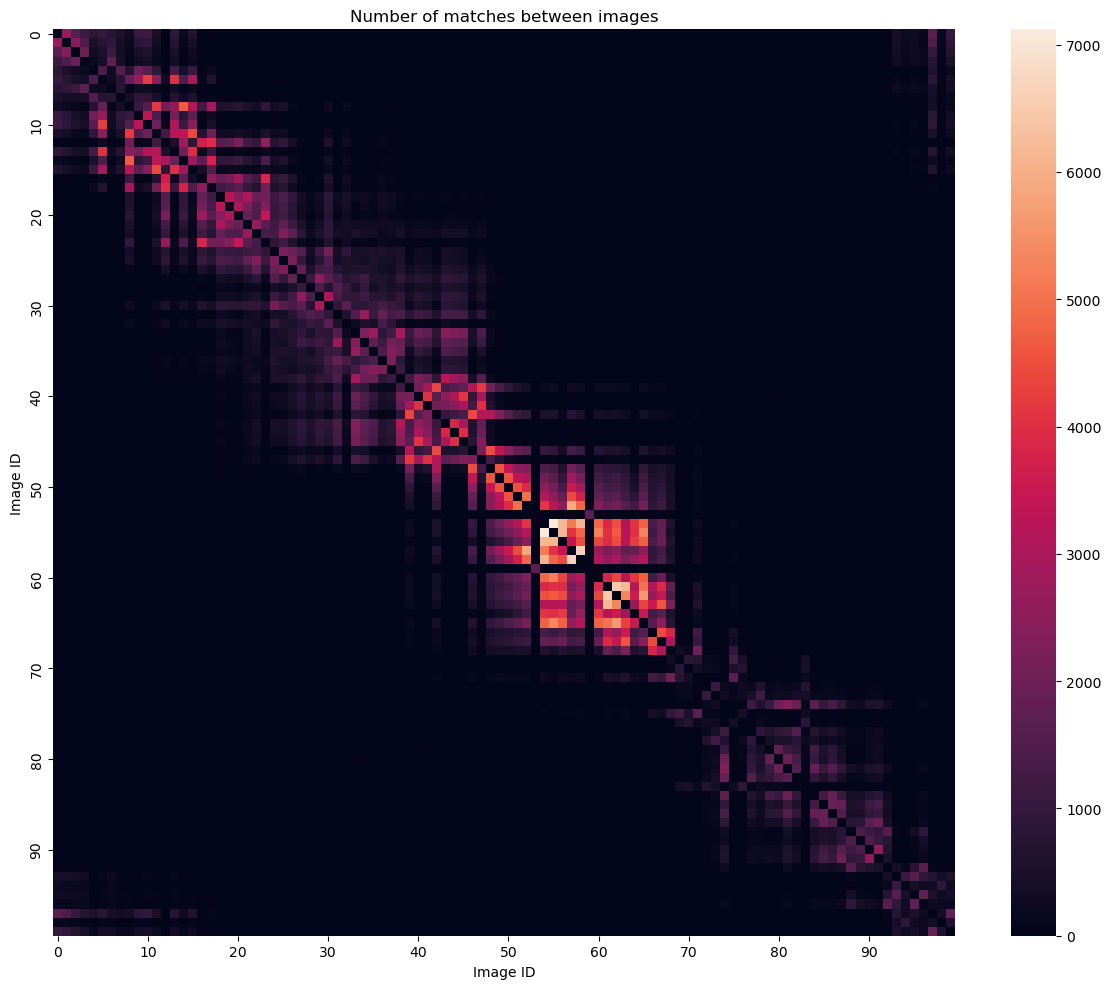

In [ ]:
### TO DO 2.4

num_images = max(images.keys())
match_matrix = np.zeros((num_images, num_images), dtype=np.int32)
for (id1, id2), match_data in matches.items():
    i, j = int(id1) - 1, int(id2) - 1
    num_matches = len(match_data)
    match_matrix[i, j] = num_matches
    match_matrix[j, i] = num_matches

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(match_matrix, xticklabels=10, yticklabels=10)
plt.xlabel('Image Id')
plt.ylabel('Image Id')
plt.title('Number of matches between images')
plt.tight_layout()
plt.show()

<span style='color:darkcyan'>Matches are concentrated around each image. An image won't have matches with images too far apart, as they represent different parts of the scene - images far appart may show different facades of the building. The fact that the corners of the heatmap are not 0 indicates that the last few images match with the first ones, indicating a somewhat closed track.</span> 

## 2.5 Visualize the keypoints and matches between the two images used in lab 3 using Colmap, how it compares to the results from lab 3? (1.0)
#### <span style='color:Green'> You can use the GUI to get the keypoints and matches and then visualize it here, following the same style as in lab 3 to get comparable results. </span>

In [ ]:
### TO DO 2.5

## 2.6 Triangulate and visualize the 3D points from the keypoints extracted using Colmap on the two images used in lab 3, how it compares to the results from lab 3? (1.0) 
#### <span style='color:Green'> - Use the triangulation from lab 3 to the get the 3D points and visualize them following the same style. </span>

In [ ]:
### TO DO 2.6

## 2.7 Visualize the sparse reconstruction using the 2 images from lab 3, and the complete CASTLE dataset. Comment on the differences between techniques and number of images used. (1.0)
#### <span style='color:Green'> - Use the reconstruction from Colmap to the get the 3D points and visualize them following the same style, using two images and the complete dataset. </span>

In [ ]:
### TO DO 2.7